### Описание шагов находится в файле task_1.ipynb, ко второму заданию идут только код и вывод

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [16]:
def run(model, dataloader, loss_function, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_labels = []
    all_preds = []

    for X, y in dataloader:
        pred = model(X)
        loss = loss_function(pred, y)
        total_loss += loss.item()
        
        _, predicted = torch.max(pred, 1)
        correct_predictions += (predicted == y).sum().item()
        total_predictions += y.size(0)
        all_labels.extend(y.tolist())
        all_preds.extend(predicted.tolist())
        
        if optimizer is not None:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    accuracy = correct_predictions / total_predictions
    avg_loss = total_loss / len(dataloader)
    
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    
    return avg_loss, accuracy, precision, recall, f1, cm

In [17]:
def show_losses(train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist):
    clear_output()

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist, label='Train Loss')
    plt.plot(np.arange(len(val_loss_hist)), val_loss_hist, label='Validation Loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(np.arange(len(train_acc_hist)), train_acc_hist, label='Train Accuracy')
    plt.plot(np.arange(len(val_acc_hist)), val_acc_hist, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.show()

In [18]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [19]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
valset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [20]:
val_size = int(0.1 * len(trainset))
test_size = int(0.1 * len(trainset))
train_size = len(trainset) - val_size - test_size
trainset, valset, testset = torch.utils.data.random_split(trainset, [train_size, val_size, test_size])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [21]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),  
    nn.ReLU(),
    nn.MaxPool2d(2), 

    nn.Conv2d(32, 64, kernel_size=3, padding=1), 
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(), 

    nn.Linear(64 * 7 * 7, 128),  
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(128, 64),  
    nn.ReLU(),           
    nn.Dropout(0.5),

    nn.Linear(64, 10)    
)

In [22]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [23]:
epochs = 20
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

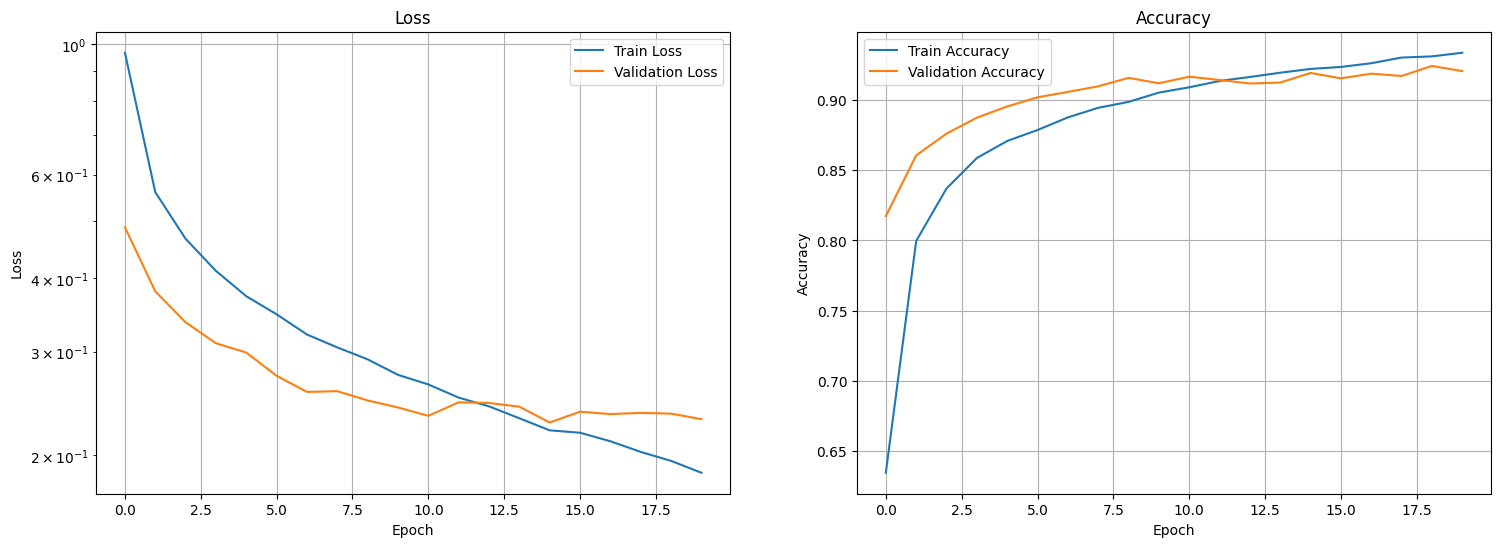

Epoch 20/20, Train Loss: 0.1866, Val Loss: 0.2302


In [24]:
for epoch in range(epochs):
    train_loss = run(model, trainloader, loss_func, optimizer)
    val_loss = run(model, valloader, loss_func)
    
    train_losses.append(train_loss[0])
    val_losses.append(val_loss[0])
    train_accuracy.append(train_loss[1])
    val_accuracy.append(val_loss[1])

    show_losses(train_losses, val_losses, train_accuracy, val_accuracy)
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss[0]:.4f}, Val Loss: {val_loss[0]:.4f}')

In [25]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 128]         401,536
              ReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 64]           8,256
             ReLU-12                   [-1, 64]               0
          Dropout-13                   [-1, 64]               0
           Linear-14                   

In [26]:
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_cm = run(model, testloader, loss_func)
val_loss, val_accuracy, val_precision, val_recall, val_f1, val_cm = run(model, valloader, loss_func)

In [27]:
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')
print('Validation Confusion Matrix:')
print(val_cm)

Validation Accuracy: 0.9205
Validation Precision: 0.9225
Validation Recall: 0.9205
Validation F1 Score: 0.9210
Validation Confusion Matrix:
[[531   0   5  17   1   1  61   0   0   0]
 [  0 627   1   7   0   0   1   0   0   0]
 [  9   0 497   5  27   0  49   0   0   0]
 [  7   3   2 584  15   0  19   0   0   0]
 [  1   0  20  15 490   0  40   0   1   0]
 [  0   0   0   0   0 610   0   7   0   4]
 [ 52   1  18  12  22   1 482   0   8   0]
 [  0   0   0   0   0   1   0 574   0   3]
 [  1   0   0   0   0   1   4   2 545   0]
 [  0   0   0   0   0   2   0  31   0 583]]


In [28]:
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print('Test Confusion Matrix:')
print(test_cm)

Test Accuracy: 0.9158
Test Precision: 0.9174
Test Recall: 0.9158
Test F1 Score: 0.9163
Test Confusion Matrix:
[[533   0   6  15   0   0  57   0   3   0]
 [  0 572   0   6   4   1   2   0   1   0]
 [ 11   0 517   3  33   0  55   0   1   0]
 [ 18   2   3 559  13   0   8   0   0   0]
 [  0   2  27  11 542   0  43   0   1   0]
 [  0   1   0   0   0 580   0  14   0   2]
 [ 51   0  17  17  37   0 485   0   1   0]
 [  0   0   0   0   0   2   0 568   0   8]
 [  1   0   0   0   0   0   4   1 612   0]
 [  0   1   0   0   0   1   0  20   1 527]]


### Модель со сверточными слоями лучше обычной модели (без сверточных слоев) по всем метрикам, что в целом логично: 

#### Модель со сверточными слоями:

- Test Accuracy: 0.9213
- Test Precision: 0.9215
- Test Recall: 0.9213
- Test F1 Score: 0.9213


#### Модель без сверточных слоев:

- Test Accuracy: 0.8750
- Test Precision: 0.8750
- Test Recall: 0.8750
- Test F1 Score: 0.8744

Помимо этого, заметны и изменения в графике лоссов: оба стали плавнее, что хорошо (в нашем случае). Заметно ухудшение ключевых показателей (accuracy, loss) в validation sample по отношению к train sample в процессе обучения - пересечение графиков, скорее всего - переобучение.